In [2]:
import sys
sys.path.append('../')
from jax import vmap, jit, grad, random, jacfwd
import jax.numpy as jnp
import numpy as np
import time
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import warnings
from jax import config
config.update("jax_enable_x64", True)
import numpyro
from interpolation.omega_gw_grid import OmegaGWGrid
from interpolation.omega_gw_jax import OmegaGWjax
from interpolation.model import Fixed_Nodes_Model
from interpolation.run import sampler
import pybobyqa
from getdist import plots,MCSamples,loadMCSamples
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=4,suppress=True)
jnp.set_printoptions(precision=4,suppress=True)
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True) # if using latex in plots
matplotlib.rc('legend', fontsize=16)


(50,)


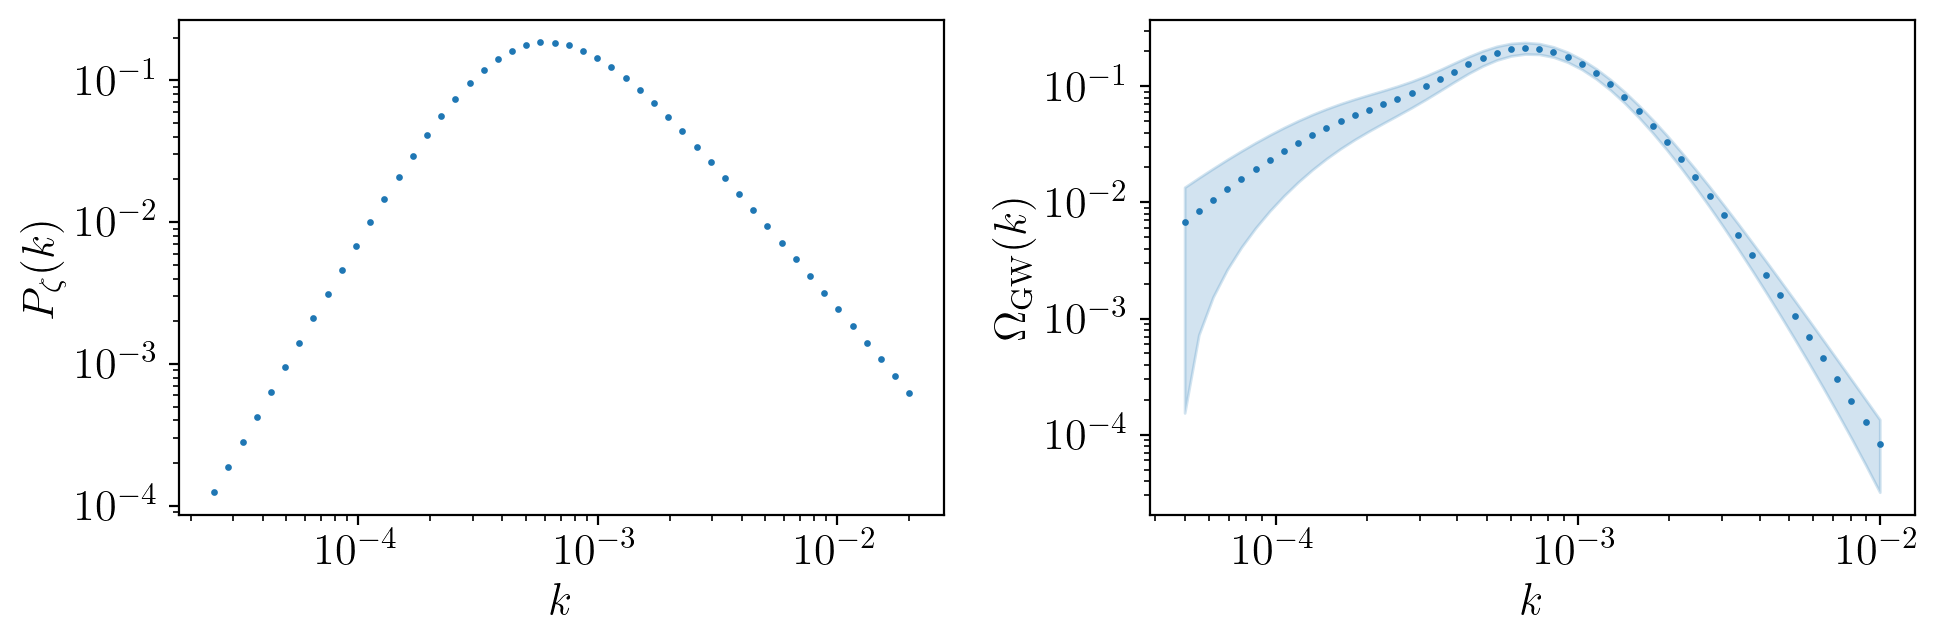

In [3]:
# set up the power spectrum and omgw
psize = 50
ksize = 50
p_arr = jnp.geomspace(2.5e-5,2e-2,psize)
k_arr = jnp.geomspace(5e-5,1e-2,ksize)

f = k_arr #jnp.geomspace(5e-5, 1e-2, ksize)  # The frequencies to calculate Omega_GW
s = jnp.linspace(0, 1, 10)  # First rescaled internal momentum
t = jnp.logspace(-4,4, 100)  # Second rescaled internal momentum

## Expand t to add a new axis
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(f), axis=-1)

@jit
def pz(p,pstar=5e-4,n1=3,n2=-2,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    # osc = (1 + 16.4*jnp.cos(1.4*jnp.log(p/1.))**2)
    return pl1 * pl2 #*osc

omgw_calculator =  OmegaGWjax(s, t, f=f, kernel="RD", upsample=False)


pz_amp = pz(p_arr)
omgw_amp = omgw_calculator(pz,f)

print(omgw_amp.shape)
kstar = 1e-3
omks_sigma = omgw_amp*( 0.05*(np.log(k_arr/kstar))**2 + 0.05) # 2% error at kstar + more towards edges
omgw_cov = jnp.diag(omks_sigma**2)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,3.5))
ax1.scatter(p_arr,pz_amp,s=2)
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.scatter(f,omgw_amp,s=2)
ax2.fill_between(k_arr,omgw_amp+1.96*omks_sigma,omgw_amp-1.96*omks_sigma,alpha=0.2,color='C0')
for ax in [ax1,ax2]:
    ax.set(yscale='log',xscale='log',xlabel=r'$k$')
fig.tight_layout();

In [4]:
kmin, kmax = min(p_arr), max(p_arr)
omgw_method_kwargs = {'s': s, 't': t}
solver = sampler(pz_kmin=kmin,pz_kmax=kmax,omgw_karr=k_arr,
                 omgw_means=omgw_amp,omgw_cov=omgw_cov,
                 omgw_method='jax',omgw_method_kwargs=omgw_method_kwargs,
                y_low=-4,y_high=1,interpolation_method='CubicSpline',min_nodes=2,max_nodes=6)

In [5]:
results = solver.run()

sample: 100%|██████████| 1024/1024 [00:27<00:00, 37.64it/s, 7 steps of size 7.45e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      y[0]     -1.13      0.02     -1.13     -1.16     -1.10    389.79      1.00
      y[1]     -2.38      0.02     -2.38     -2.41     -2.36    326.70      1.00

Number of divergences: 0
First few samples: {'y': Array([[-1.1157, -2.3709],
       [-1.1474, -2.3944],
       [-1.1213, -2.3793],
       [-1.1066, -2.4239],
       [-1.1497, -2.3358]], dtype=float64)}
[-1.127  -2.3788]
Number of nodes: 2, chi2: 2393.5952, aic: 2397.5952, 'best_params': [-1.1257 -2.3783]


sample: 100%|██████████| 1024/1024 [00:50<00:00, 20.35it/s, 7 steps of size 4.93e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      y[0]     -3.22      0.03     -3.22     -3.27     -3.18    199.23      1.02
      y[1]     -0.82      0.00     -0.82     -0.82     -0.81    571.92      1.00
      y[2]     -4.00      0.00     -4.00     -4.00     -3.99    342.55      1.00

Number of divergences: 0
First few samples: {'y': Array([[-3.2175, -0.817 , -3.9826],
       [-3.1883, -0.8176, -3.9951],
       [-3.2099, -0.8227, -3.994 ],
       [-3.2124, -0.8151, -3.9956],
       [-3.2066, -0.8214, -3.9968]], dtype=float64)}
[-3.2298 -0.8179 -3.9952]
Number of nodes: 3, chi2: -134.8439, aic: -128.8439, 'best_params': [-3.2331 -0.8181 -4.    ]


sample: 100%|██████████| 1024/1024 [00:56<00:00, 18.09it/s, 7 steps of size 4.29e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      y[0]     -3.98      0.02     -3.99     -4.00     -3.95    471.12      1.00
      y[1]     -1.02      0.01     -1.02     -1.03     -1.01    583.71      1.00
      y[2]     -1.28      0.00     -1.28     -1.28     -1.27    636.46      1.00
      y[3]     -3.97      0.03     -3.98     -4.00     -3.93    335.70      1.00

Number of divergences: 0
First few samples: {'y': Array([[-3.9863, -1.0211, -1.2754, -3.9926],
       [-3.9336, -1.0218, -1.2731, -3.9979],
       [-3.9904, -1.0196, -1.2811, -3.9585],
       [-3.991 , -1.0117, -1.2788, -3.9804],
       [-3.9495, -1.025 , -1.277 , -3.9541]], dtype=float64)}
[-3.9799 -1.0235 -1.275  -3.9601]
Number of nodes: 4, chi2: -186.0126, aic: -178.0126, 'best_params': [-4.     -1.0265 -1.2763 -4.    ]


sample: 100%|██████████| 1024/1024 [02:24<00:00,  7.09it/s, 63 steps of size 6.71e-02. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      y[0]     -2.72      0.49     -2.85     -3.20     -1.87      2.95      2.03
      y[1]     -1.62      0.15     -1.59     -1.92     -1.39      8.12      1.04
      y[2]     -0.75      0.04     -0.75     -0.79     -0.67      8.81      1.00
      y[3]     -2.15      0.55     -1.81     -3.12     -1.78      3.37      1.55
      y[4]     -2.62      0.29     -2.76     -2.95     -2.11      3.46      1.85

Number of divergences: 95
First few samples: {'y': Array([[-1.5856, -1.2821, -0.9114, -3.2313, -1.9071],
       [-1.589 , -1.2845, -0.9114, -3.2297, -1.9071],
       [-1.5952, -1.2841, -0.9049, -3.227 , -1.913 ],
       [-1.6012, -1.2867, -0.9018, -3.2251, -1.9177],
       [-1.602 , -1.2877, -0.9009, -3.2239, -1.9197]], dtype=float64)}
[-3.1393 -1.5993 -0.7532 -1.7985 -2.7843]
Number of nodes: 5, chi2: -244.4463, aic: -234.4463, 'best_params': [-4.     -1.6854 -0.7497 -1.7965 -2.7193]


sample: 100%|██████████| 1024/1024 [01:43<00:00,  9.88it/s, 63 steps of size 4.18e-02. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      y[0]     -1.53      0.41     -1.40     -2.18     -1.04      2.69      2.30
      y[1]     -1.50      0.36     -1.30     -2.11     -1.22      3.20      1.72
      y[2]     -1.06      0.14     -1.07     -1.27     -0.86      2.51      2.72
      y[3]     -2.26      0.80     -2.66     -2.96     -1.00      3.06      1.85
      y[4]     -2.43      0.18     -2.51     -2.56     -2.08      4.20      1.28
      y[5]     -3.14      0.10     -3.10     -3.32     -3.03      2.90      2.04

Number of divergences: 382
First few samples: {'y': Array([[-1.0125, -1.2093, -1.2734, -2.9876, -2.4972, -3.0273],
       [-1.0124, -1.2062, -1.2709, -2.9889, -2.4976, -3.0267],
       [-1.0136, -1.2071, -1.2681, -2.9834, -2.4973, -3.0292],
       [-1.0137, -1.2083, -1.268 , -2.9828, -2.4975, -3.0292],
       [-1.0131, -1.2081, -1.2681, -2.9822, -2.4978, -3.0289]],      dtype=float64)}
[-2.1156 -2.1023 -0.862  -1.0132 -2.0733 -

(1e-05, 1.0)

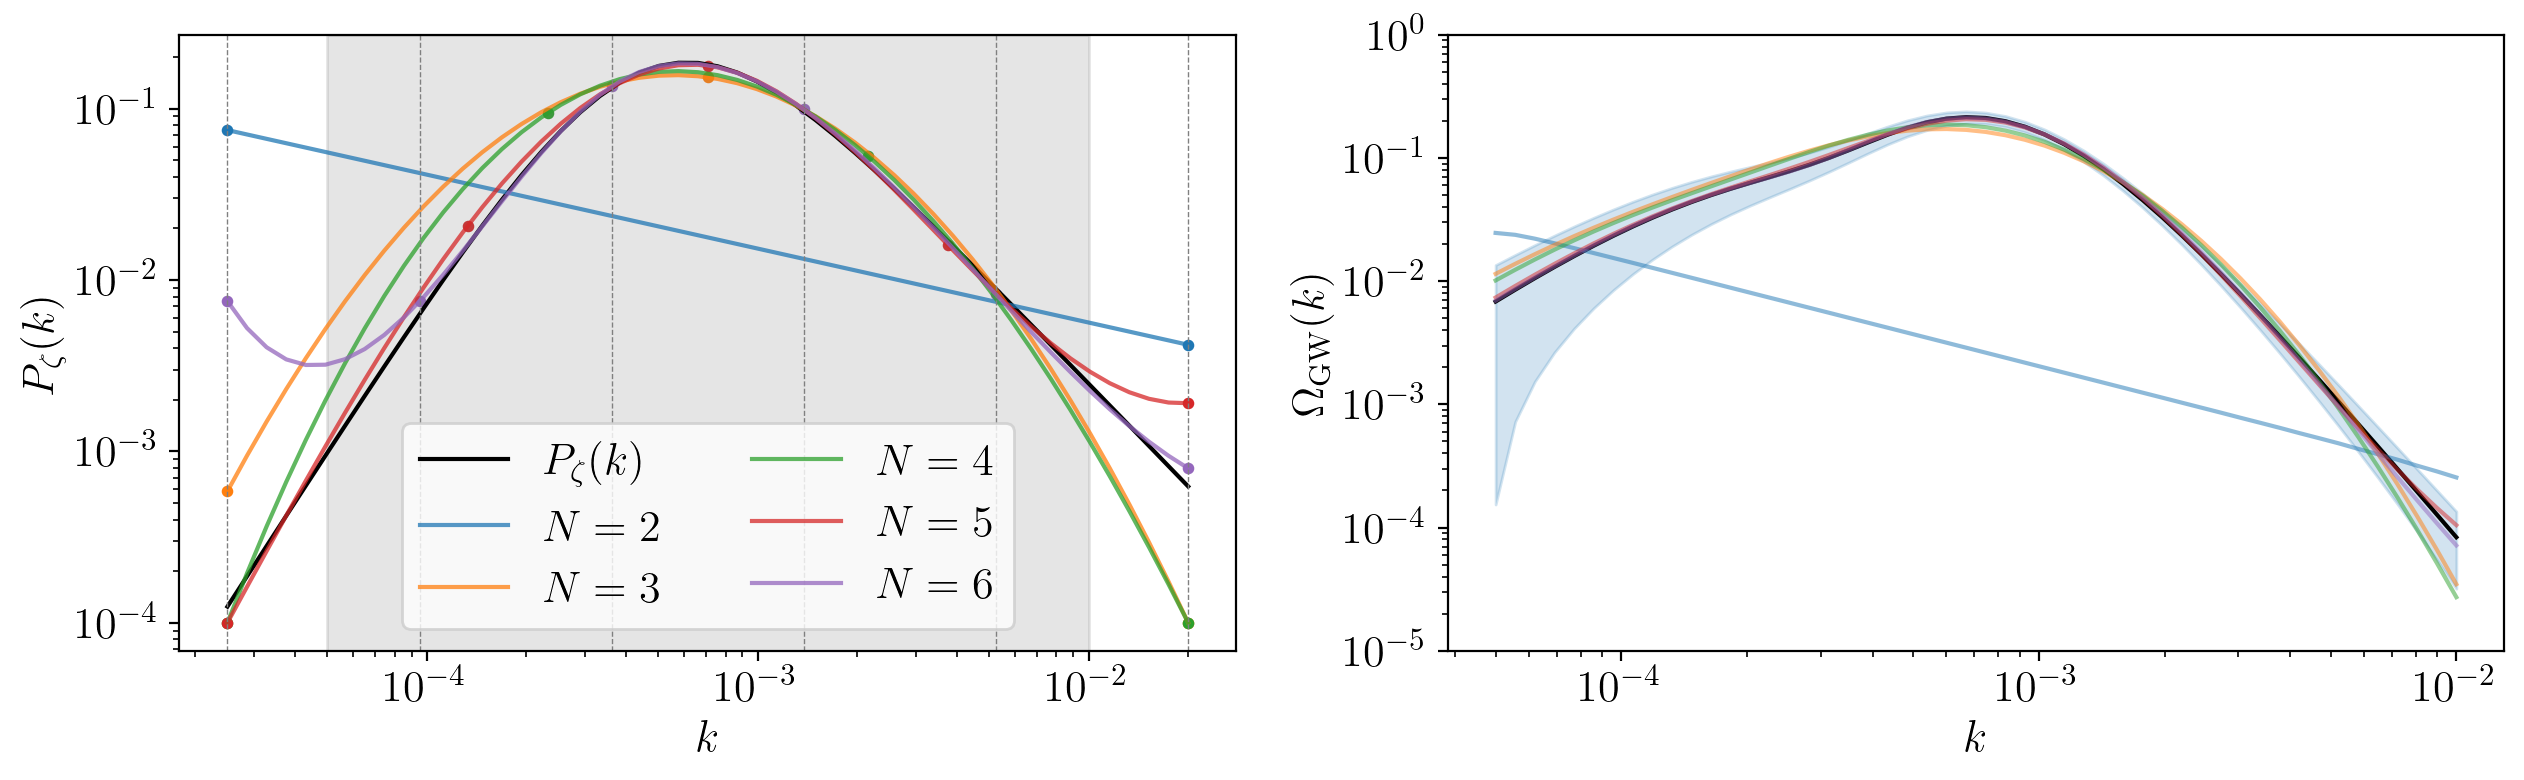

In [6]:
from interpolation.model import spline_predict


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4))
ax1.loglog(p_arr,pz_amp,label=r'$P_{\zeta}(k)$',color='k',lw=1.5)
ax2.loglog(f,omgw_amp,label=r'Truth',color='k',lw=1.5)
n_nodes = [2,3,4,5,6]
for n in n_nodes:
    res = results[str(n)]
    nodes = res['node_locations']
    best_params = res['best_params']
    def pz_bf(x):
        val = spline_predict(x_train=nodes,y_train=best_params,x_pred=x) #
        val = jnp.where(jnp.log(x)<jnp.log(kmin),0.,val)
        val = jnp.where(jnp.log(x)>jnp.log(kmax),0.,val)
        return val
    pz = pz_bf(p_arr)
    omgw_bf = omgw_calculator(pz_bf,k_arr) #jnp.einsum("i,j,kij->k",pz_bf,pz_bf,omgw_calculator.omkij)
    ax1.loglog(p_arr,pz,label=f'$N = {n}$',alpha=0.75)
    ax1.scatter(10**(nodes),10**(best_params),s=10)
    ax2.loglog(k_arr,omgw_bf,label=f'$N = {n}$',alpha=0.5)
for node in nodes:
    ax1.axvline(10**(node),color='gray',ls='--',lw=0.5)
for x in [ax1,ax2]:
    x.set(xlabel=r'$k$',yscale='log',xscale='log')
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax2.fill_between(k_arr,omgw_amp+1.96*omks_sigma,omgw_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax1.legend(ncol=2)
ax1.axvspan(min(k_arr),max(k_arr),color='gray',alpha=0.2)
ax2.set_ylim(1e-5,1.)